# Processing video with image processing operators

In this tutorial we will see several examples of processing video with image processing operators. 

We will focus on how to use [fn.per_frame](../../../operations/nvidia.dali.fn.per_frame.html) operator to specify temporal arguments, i.e. control arguments for each frame of the processed video. We will load the video as batches of sequences of frames (batches with `FHWC` sample [layout](../../../data_types.html#data-layouts)) with [fn.readers.video_resize](../../../operations/nvidia.dali.fn.readers.video_resize.html) operator.

Let us start by defining some utilities to display the results.

In [1]:
import base64
import io
from PIL import Image, ImageDraw
from IPython import display

def draw_points(images, points):
    assert(len(points) == len(images))
    for frame_points, image in zip(points, images):
        draw = ImageDraw.Draw(image)
        for x, y in frame_points:
            draw.ellipse((x - 3, y - 3, x + 3, y + 3), fill="blue", outline="blue")

def display_video(batch, duration=50, points=None):
    images = [Image.fromarray(frame) for sequence in batch for frame in np.array(sequence)]
    if points is not None:
        points = [frame_points for sequence in points for frame_points in np.array(sequence)]
        draw_points(images, points)
    image, *images = images
    with io.BytesIO() as file:
        image.save(file, save_all=True, append_images=images,
                   duration=duration, loop=0, format="webp",
                   minimize_size=True)
        display.display(display.Image(data=file.getvalue()))

We set the DALI_EXTRA_PATH to point to [DALI extra repository](https://github.com/NVIDIA/DALI_extra) with the *Sintel* movie trailer that we will use in the examples.

In [2]:
import os

num_frames, num_channels = 30, 3
roi_start = (90, 0)
roi_end = (630, 1280)

vid_dir = os.path.join(os.environ['DALI_EXTRA_PATH'], "db", "video", "sintel", "video_files")
vid_files = ["sintel_trailer-720p_3.mp4"]
vid_filenames = [os.path.join(vid_dir, vid_file) for vid_file in vid_files]

Let us define pipeline that reads and [rotates](../../../operations/nvidia.dali.fn.rotate.html) video by an angle provided via the [external_source](../../../operations/nvidia.dali.fn.external_source.html).

In [3]:
import math
import numpy as np

from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types

height, width = 144, 256
diag = math.ceil(math.sqrt(height*height + width*width))

@pipeline_def
def per_sample_pipeline(angle_source):
    video = fn.readers.video_resize(
        filenames=vid_filenames,
        name='video reader',
        sequence_length=num_frames,
        file_list_include_preceding_frame=True,
        device='gpu',
        roi_start=roi_start,
        roi_end=roi_end,
        seed=42,
        resize_x=width,
        resize_y=height)
    angle = fn.external_source(source=angle_source, batch=False)
    rotated = fn.rotate(video, angle=angle, size=[diag, diag], fill_value=255)
    return rotated

We run the [external_source](../../../operations/nvidia.dali.fn.external_source.html) in a sample mode (`batch=False`). The `source` callback will be called by with [SampleInfo](../../../data_types.html#sampleinfo) instance for each sample (sequence) in the batch. This way we control rotation angle for each sequence in the dataset.

We used `num_frames=30` and `batch_size=4` which means that a single batch consists of total 120 frames, grouped into 4 sequences. Each of the 4 sequences will be rotated by a different angle.

In [4]:
def sample_rotate(sample_info):
    return np.array(-10 * sample_info.idx_in_epoch, dtype=np.float32)

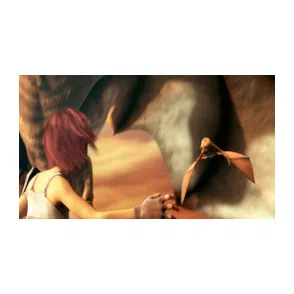

In [5]:
pipe = per_sample_pipeline(batch_size=4, device_id=0, num_threads=4, angle_source=sample_rotate)
pipe.build()
(video,) = pipe.run()
display_video(video.as_cpu())

In the presented example, we can see that subsequent fragments of the video are rotated by a different angle.

However, when processing video you may need a finer control over parameters. For example, in the rotation case, you may need to specify different angle for each frame in each sequence. The [fn.per_frame](../../../operations/nvidia.dali.fn.per_frame.html) operator makes it possible.

We need to tweak two things to make it work. 

Firstly, we need to modify the callback. Instead of a single angle for a given sequence it will return an array of angles. The size of the array must match the number of frames in the corresponding video sequence. In our case there are always `num_frames=30` frames in any sequence.

Secondly, in the pipeline we wrap the angle parameter with a [fn.per_frame](../../../operations/nvidia.dali.fn.per_frame.html) call to hint the [fn.rotate](../../../operations/nvidia.dali.fn.rotate.html) operator it should use the angles on a per-frame basis.

In [6]:
def frame_rotate(sample_info):
    return np.linspace(0, -30, num_frames, dtype=np.float32)

In [7]:
@pipeline_def
def per_frame_pipeline(angle_source):
    video = fn.readers.video_resize(
        filenames=vid_filenames,
        name='video reader',
        sequence_length=num_frames,
        file_list_include_preceding_frame=True,
        device='gpu',
        roi_start=roi_start,
        roi_end=roi_end,
        seed=42,
        resize_x=width,
        resize_y=height)
    angle = fn.external_source(source=angle_source, batch=False)
    rotated = fn.rotate(video, angle=fn.per_frame(angle), size=[diag, diag], fill_value=255)
    return rotated

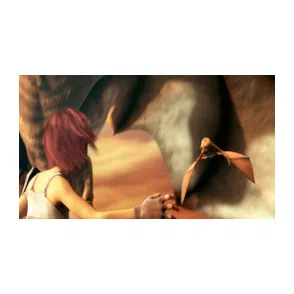

In [8]:
pipe = per_frame_pipeline(batch_size=4, device_id=0, num_threads=4, angle_source=frame_rotate)
pipe.build()
(video,) = pipe.run()
display_video(video.as_cpu())

In the presented example, we used a different angle for each frame of the sequence, but the angle vector was the same across different sequences. Let us change that by modifying the callback so that it uses the provided [SampleInfo](../../../data_types.html#sampleinfo) instance to shift the angles depending on the `sample_info.idx_in_epoch`.

In [9]:
def frame_rotate(sample_info):
    quarter = np.linspace(0, -90, num_frames, endpoint=False, dtype=np.float32)
    return quarter - 90 * sample_info.idx_in_epoch

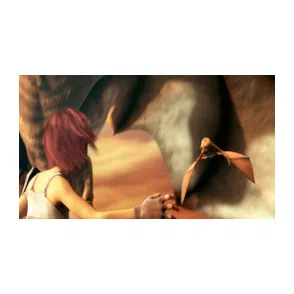

In [10]:
pipe = per_frame_pipeline(batch_size=4, device_id=0, num_threads=4, angle_source=frame_rotate)
pipe.build()
(video,) = pipe.run()
display_video(video.as_cpu())

Now, let us consider slightly more involved example that combines [fn.warp_affine](../../../operations/nvidia.dali.fn.warp_affine.html) and [fn.gaussian_blur](../../../operations/nvidia.dali.fn.gaussian_blur.html) operators. 

The [fn.warp_affine](../../../operations/nvidia.dali.fn.warp_affine.html) will use [fn.per_frame](../../../operations/nvidia.dali.fn.per_frame.html) parameters provided through [fn.external_source](../../../operations/nvidia.dali.fn.external_source.html) to apply different transformations to consecutive sequences. 
In contrast, the [fn.gaussian_blur](../../../operations/nvidia.dali.fn.gaussian_blur.html) operator will use the same series of parameters for each sequence in the dataset. For that we do not need to use [fn.external_source](../../../operations/nvidia.dali.fn.external_source.html), instead we can define the array directly in the pipeline.

In [11]:
height, width = 216, 384
max_sigma = 5
batch_size = 8


def compose(*transforms):
    h, *t = transforms
    return h if not t else np.matmul(h, compose(*t))

def translate(offsets):
    return np.array([[[1, 0, tw], [0, 1, th], [0, 0, 1]] for tw, th in offsets])

def scale(scales):
    return np.array([[[sw, 0, 0], [0, sh, 0], [0, 0, 1]] for sw, sh in scales])
    
def rotate(angles):
    css = [(np.cos(angle), np.sin(angle)) for angle in (math.radians(angle) for angle in angles)]
    return np.array([[[c, -s, 0], [s, c, 0], [0, 0, 1]] for c, s in css])

def rotate_center(angles):
    pre_rot = translate([(-0.5 * width, -0.5 * height)] * len(angles))
    return compose(np.linalg.inv(pre_rot), rotate(angles), pre_rot)

def align_center(sizes):
    return translate([((width - w) / 2, (height - h) / 2) for w, h in sizes])

def move(rs, angles):
    def shift(r, angle):
        dw = r * np.sin(math.radians(angle))
        dh = r * np.cos(math.radians(angle))
        return (dw, dh)
    return translate([shift(r, angle) for r, angle in zip(rs, angles)])

def zoom(start, end):
    scaling = np.linspace(start, end, num_frames)
    s = scale(zip(scaling, scaling))
    t = align_center([(width * s, height * s) for s in scaling])
    return compose(t, s)

def shake():
    max_angle = 30
    angles = np.sin(np.linspace(0, 5 * np.pi, num_frames)) * max_angle * np.linspace(1, 0.25, num_frames)
    return rotate_center(angles)

def circle(r, angle_start, angle_end):
    angles = np.linspace(angle_start, angle_end, num_frames, endpoint=False)
    return compose(move([r] * num_frames, angles), rotate_center(angles - 90))

def create_warp_ms_source():
    r = height//3 - 0.125 * height
    
    def affine(transform):
        return np.array([frame_transform[0:2] for frame_transform in transform], dtype=np.float32)
    
    def animation(sample_info):
        i = sample_info.idx_in_batch
        if i == 0:
            return zoom(1, 0.5)
        if i == 1:
            return compose(zoom(0.5, 0.5), shake())
        if i == 2:
            move_right = move(np.linspace(0, r, num_frames), [90] * num_frames)
            return compose(move_right, zoom(0.5, 0.25))
        if i == 7:
            move_back = move(np.linspace(r, 0, num_frames), [90] * num_frames)
            return compose(move_back, zoom(0.25, 1))
        # for samples 3, 4, 5, 6
        return compose(circle(r, 90 * (i - 2), 90 * (i - 1)), zoom(0.25, 0.25))
    
    return lambda sample_info: affine(animation(sample_info))
        

In [12]:
@pipeline_def
def pipeline():
    video = fn.readers.video_resize(
        filenames=vid_filenames,
        name='video reader',
        sequence_length=num_frames,
        file_list_include_preceding_frame=True,
        device='gpu',
        roi_start=roi_start,
        roi_end=roi_end,
        seed=42,
        resize_x=width,
        resize_y=height)
    warp_matrix = fn.external_source(source=create_warp_ms_source(), batch=False)
    video = fn.warp_affine(video, fn.per_frame(warp_matrix), fill_value=255, inverse_map=False)
    sigma = np.sin(np.linspace(0, np.pi, num_frames)) * max_sigma
    window_size = np.array(2 * np.ceil(sigma) + 1, dtype=np.int32)
    video = fn.gaussian_blur(video, window_size=fn.per_frame(window_size), sigma=fn.per_frame(sigma))
    return video

In [13]:
pipe = pipeline(batch_size=batch_size, device_id=0, num_threads=4)
pipe.build()
(vid,) = pipe.run()

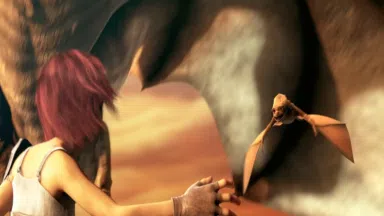

In [14]:
display_video(vid.as_cpu().as_array())

Computing the transformation matrices by hand may be tiresome. Fortunately DALI comes with a family of [fn.transforms](../../../operations/nvidia.dali.fn.transforms.html) operators that facilities the task. Let us consider similar example, but this time limiting usage of the external source in favour of the DALI transforms.

Further, the example will illustrate how to apply the same transforms to a set of keypoints with the [fn.coord_transform](../../../operations/nvidia.dali.fn.coord_transform.html) operator.

In [15]:
import nvidia.dali.math as dali_math

height, width = 216, 384
r = height//3 - 0.125 * height
scale = 0.35

def angle_source(sample_info):
    i = sample_info.idx_in_batch
    angle_deg = np.linspace(90 * (i + 1), 90 * (i + 2), num_frames, dtype=np.float32, endpoint=False)
    return angle_deg, np.deg2rad(angle_deg)

def coord_source(sample_info):
    # let us track how corners and the center of the image are transformed
    return np.array([[0, 0], [0, height], [width, 0], [width, height], [width // 2, height // 2]], dtype=np.int32)

In [16]:
@pipeline_def
def pipeline():
    video = fn.readers.video_resize(
        filenames=vid_filenames,
        name='video reader',
        sequence_length=num_frames,
        file_list_include_preceding_frame=True,
        device='gpu',
        roi_start=roi_start,
        roi_end=roi_end,
        seed=42,
        resize_x=width,
        resize_y=height)
    angle_deg, angle_rad = fn.external_source(source=angle_source, batch=False, num_outputs=2)
    shifted_angle = angle_rad + 90
    
    # np.sin(*) will be treated as a constant - for every sequence we reuse the same shear_angle tensor
    shear_angle = np.sin(np.linspace(0, 2 * np.pi, num_frames, endpoint=False), dtype=np.float32) * 15
    shear_angles = fn.stack(shear_angle, shear_angle, axis=1)
    shear = fn.transforms.shear(angles=fn.per_frame(shear_angles), center=[width/2, height/2])
    
    rotation = fn.transforms.rotation(angle=fn.per_frame(angle_deg), center=[width/2, height/2])
    
    # we are using nvidia.dali.math arithmetic to compute sin and cos in each iteration
    shift_s = r * dali_math.sin(shifted_angle)
    shift_c = r * dali_math.cos(shifted_angle)
    move_offset = fn.stack(shift_s, shift_c, axis=1)
    move = fn.transforms.translation(offset=fn.per_frame(move_offset))
    
    zoomed_out = fn.transforms.scale(scale=[scale, scale], center=[width/2, height/2])
    
    # zoomed_out is broadcast when combined with per-frame rotation and move
    circle_rotate = fn.transforms.combine(zoomed_out, shear, rotation, move)
    
    coord = fn.external_source(source=coord_source, batch=False)
    coord_transformed = fn.coord_transform(coord, MT=circle_rotate)
    # the circle_rotate is already per-frame, wrapping it with per_frame call is optional
    video = fn.warp_affine(video, matrix=circle_rotate, fill_value=255, inverse_map=False)
    return video, coord_transformed

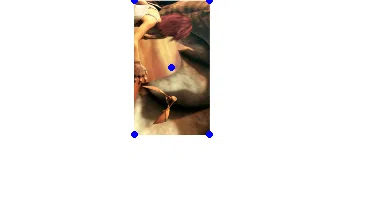

In [17]:
pipe = pipeline(batch_size=batch_size, device_id=0, num_threads=4)
pipe.build()
(vid,coord_transformed) = pipe.run()
display_video(vid.as_cpu().as_array(), points=coord_transformed)